# 调试 GSE249057 数据处理脚本

本 notebook 用于处理 GSE249057 数据集，包括：
1. 加载不同时间点的单细胞数据
2. 将时间点视为不同批次
3. 转换为h5ad格式并保存
4. 绘制批次矫正前的UMAP可视化图
5. 使用批次矫正技术处理批次效应
6. 绘制批次矫正后的UMAP可视化图

In [117]:
# 导入必要的库
import sys
from pathlib import Path

# Add project root to Python path
sys.path.append("/your/path/to/TOMIC")

import os
import random
import warnings

warnings.filterwarnings("ignore")

import anndata as ad
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tomic import get_logger

# Use unified logger
logger = get_logger("data_process")

# 设置随机种子
random.seed(42)
np.random.seed(42)

# 设置scanpy参数
sc.settings.verbosity = 3  # verbosity level
sc.settings.set_figure_params(dpi=100, facecolor="white")

print("库导入成功！")

库导入成功！


In [118]:
from pprint import pprint

# 配置数据路径
DATA_DIR = "/your/path/to/raw/data/GSE249057_RAW"
OUTPUT_DIR = Path("/your/path/to/raw/data/GSE249057_processed")

# 创建输出目录
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# 检查数据目录是否存在
if os.path.exists(DATA_DIR):
    print(f"✓ 数据目录存在: {DATA_DIR}")
    files = os.listdir(DATA_DIR)
    print(f"✓ 找到 {len(files)} 个文件")
    pprint(f"文件: {sorted(files)}")
else:
    print(f"✗ 数据目录不存在: {DATA_DIR}")

✓ 数据目录存在: /your/path/to/raw/data/GSE249057_RAW
✓ 找到 17 个文件
('文件: '
 "['GSE249056_GuanXY_RNASeq_CPOS-210820-CNW-9185a_Gene_DiffExpressed.xlsx', "
 "'GSE249056_GuanXY_RNASeq_CPOS-210820-CNW-9185a_Transcript_DiffExpressed.xlsx', "
 "'GSM7925719_0h_barcodes.tsv.gz', 'GSM7925719_0h_features.tsv.gz', "
 "'GSM7925719_0h_matrix.mtx.gz', 'GSM7925720_6h_barcodes.tsv.gz', "
 "'GSM7925720_6h_features.tsv.gz', 'GSM7925720_6h_matrix.mtx.gz', "
 "'GSM7925721_48h_barcodes.tsv.gz', 'GSM7925721_48h_features.tsv.gz', "
 "'GSM7925721_48h_matrix.mtx.gz', 'GSM7925722_2mo_barcodes.tsv.gz', "
 "'GSM7925722_2mo_features.tsv.gz', 'GSM7925722_2mo_matrix.mtx.gz', "
 "'GSM7925723_4mo_barcodes.tsv.gz', 'GSM7925723_4mo_features.tsv.gz', "
 "'GSM7925723_4mo_matrix.mtx.gz']")


In [119]:
# 定义样本名称（不同时间点）
SAMPLE_NAMES = [
    "GSM7925719_0h",  # 0小时
    "GSM7925720_6h",  # 6小时
    "GSM7925721_48h",  # 48小时
    "GSM7925722_2mo",  # 2个月
    "GSM7925723_4mo",  # 4个月
]

# 时间点到批次的映射
TIME_TO_BATCH = {
    "GSM7925719_0h": "0h",
    "GSM7925720_6h": "6h",
    "GSM7925721_48h": "48h",
    "GSM7925722_2mo": "2mo",
    "GSM7925723_4mo": "4mo",
}

print(f"✓ 找到 {len(SAMPLE_NAMES)} 个时间点样本")
print("样本列表:")
for i, name in enumerate(SAMPLE_NAMES, 1):
    print(f"  {i}. {name} -> 批次: {TIME_TO_BATCH[name]}")

# 检查样本文件是否存在
print("\n检查样本文件:")
for sample_name in SAMPLE_NAMES:
    matrix_file = os.path.join(DATA_DIR, sample_name + "_matrix.mtx.gz")
    features_file = os.path.join(DATA_DIR, sample_name + "_features.tsv.gz")
    barcodes_file = os.path.join(DATA_DIR, sample_name + "_barcodes.tsv.gz")

    exists = all(os.path.exists(f) for f in [matrix_file, features_file, barcodes_file])
    status = "✓" if exists else "✗"
    print(f"{status} {sample_name}: {exists}")

✓ 找到 5 个时间点样本
样本列表:
  1. GSM7925719_0h -> 批次: 0h
  2. GSM7925720_6h -> 批次: 6h
  3. GSM7925721_48h -> 批次: 48h
  4. GSM7925722_2mo -> 批次: 2mo
  5. GSM7925723_4mo -> 批次: 4mo

检查样本文件:
✓ GSM7925719_0h: True
✓ GSM7925720_6h: True
✓ GSM7925721_48h: True
✓ GSM7925722_2mo: True
✓ GSM7925723_4mo: True


In [120]:
# 加载单个样本的函数
def load_sample_data(sample_name: str, data_dir: str) -> ad.AnnData:
    """Load a single sample from the dataset (MTX format)."""
    matrix_file = os.path.join(data_dir, sample_name + "_matrix.mtx.gz")
    features_file = os.path.join(data_dir, sample_name + "_features.tsv.gz")
    barcodes_file = os.path.join(data_dir, sample_name + "_barcodes.tsv.gz")

    # Load matrix data
    adata = sc.read_mtx(matrix_file).T  # Transpose to have cells as rows

    # Load features and barcodes
    features = pd.read_csv(features_file, header=None, sep="\t")
    barcodes = pd.read_csv(barcodes_file, header=None, sep="\t")

    # Set gene information
    if features.shape[1] > 1:
        adata.var["gene_symbols"] = features[1].values
        adata.var_names = features[0].values
    else:
        adata.var["gene_symbols"] = features[0].values
        adata.var_names = features[0].values

    # Set cell information
    adata.obs["barcode"] = barcodes[0].values
    adata.obs_names = [f"{sample_name}_{bc}" for bc in adata.obs["barcode"]]
    adata.obs["sample"] = sample_name
    adata.obs["timepoint"] = TIME_TO_BATCH[sample_name]
    adata.obs["batch"] = TIME_TO_BATCH[sample_name]  # 将时间点作为批次

    return adata


# 测试加载第一个样本
# test_sample = SAMPLE_NAMES[0]
# print(f"测试加载样本: {test_sample}")
# test_adata = load_sample_data(test_sample, DATA_DIR)
# print(f"✓ 成功加载样本 {test_sample}")
# print(f"  形状: {test_adata.shape}")
# print(f"  基因数: {test_adata.n_vars}")
# print(f"  细胞数: {test_adata.n_obs}")
# print(f"  观察列: {test_adata.obs.columns.tolist()}")
# print(f"  变量列: {test_adata.var.columns.tolist()}")

In [121]:
# 保存原始合并后的数据为h5ad格式
raw_h5ad_path = OUTPUT_DIR / "GSE249057_raw_combined.h5ad"

if not os.path.exists(raw_h5ad_path):
    # 合并所有样本
    def combine_samples(sample_names: list[str], data_dir: str) -> ad.AnnData:
        """Load and combine multiple samples into a single AnnData object."""
        if not sample_names:
            raise ValueError("sample_names must be non-empty")

        adata_list = []
        features = None

        for sample_name in sample_names:
            print(f"  加载样本: {sample_name}...")
            adata = load_sample_data(sample_name, data_dir)
            adata_list.append(adata)

            if features is None:
                features_file = os.path.join(data_dir, sample_name + "_features.tsv.gz")
                features = pd.read_csv(features_file, header=None, sep="\t")

        # Combine all samples
        print("合并样本...")
        adata_combined = sc.concat(adata_list, join="outer", fill_value=0)

        # Set gene symbols for all genes
        if features is not None:
            if features.shape[1] > 1:
                gene_symbols_dict = dict(zip(features[0], features[1]))
            else:
                gene_symbols_dict = dict(zip(features[0], features[0]))

            # Map gene symbols
            adata_combined.var["gene_symbols"] = [
                gene_symbols_dict.get(gene, gene) for gene in adata_combined.var_names
            ]

        return adata_combined

    print("合并所有样本...")
    adata_combined = combine_samples(SAMPLE_NAMES, DATA_DIR)
    print(f"\n✓ 成功合并所有样本")
    print(f"  总形状: {adata_combined.shape}")
    print(f"  总基因数: {adata_combined.n_vars}")
    print(f"  总细胞数: {adata_combined.n_obs}")
    print(f"\n批次分布:")
    print(adata_combined.obs["batch"].value_counts().sort_index())
    print(f"保存原始合并数据到: {raw_h5ad_path}")
    adata_combined.write(raw_h5ad_path)
    print(f"✓ 保存成功")

else:
    print(f"✓ 已存在原始合并数据: {raw_h5ad_path}")
    adata_combined = ad.read_h5ad(raw_h5ad_path)

# 数据预处理：标准化、log转换、高变基因选择

✓ 已存在原始合并数据: /your/path/to/raw/data/GSE249057_processed/GSE249057_raw_combined.h5ad


In [122]:
import numpy as np
import scanpy as sc
import scanpy.external as sce
from scanpy.get import _get_obs_rep, _set_obs_rep

adata = adata_combined.copy()
adata.obs_names = [x.split("_", 1)[1] for x in adata.obs_names]
print(f"  过滤前形状: {adata.shape}")

# adata: 读入所有样本拼起来（obs 里要有 timepoint/batch）
# sc.read_10x_mtx(...) 或读 h5ad 都行

# 1) QC 指标
adata.var["mt"] = adata.var["gene_symbols"].str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

# 2) 过滤（对应你的阈值）
adata = adata[
    (adata.obs["n_genes_by_counts"] >= 200)
    & (adata.obs["n_genes_by_counts"] <= 8000)
    & (adata.obs["total_counts"] >= 1000)
    & (adata.obs["pct_counts_mt"] <= 15),
    :,
].copy()

print(f"  过滤后形状: {adata.shape}")
# 3) Normalize 到 1e4 + log
sc.pp.normalize_total(adata, target_sum=1e4)

_set_obs_rep(
    adata,
    _get_obs_rep(adata),
    layer="X_log1p",
)
# sc.pp.log1p(adata, layer="X_log1p")


# 4) PCA=50
# sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, n_comps=50)

# 5) HVG=2000（建议用 seurat_v3 flavor）
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="seurat_v3", batch_key="batch")
adata = adata[:, adata.var["highly_variable"]].copy()


cluster_LABEL = pd.read_csv("GSE249057_integrated_metadata.csv", index_col=0)[["Cluster_S_label"]].rename(
    columns={"Cluster_S_label": "Cluster S"}
)
adata_index = [x for x in adata.obs_names if x in cluster_LABEL.index]
adata = adata[adata_index]
adata.obs["Cluster S"] = adata.obs.merge(cluster_LABEL, left_index=True, right_index=True)["Cluster S"]

  过滤前形状: (26712, 33538)
  过滤后形状: (19986, 33538)
normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:34)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [123]:
adata.obs["organ"] = adata.obs["Cluster S"]
adata.obs["dataset"] = adata.obs["timepoint"].map(
    {
        "0h": "primary",
        "4mo": "metastasis",
    }
)
# to array
adata.layers["X_log1p"] = adata.layers["X_log1p"].toarray()
adata.X = adata.X.toarray()

In [124]:
adata = adata[adata.obs["dataset"].isin(["primary", "metastasis"])]

In [125]:
import json

p = Path("/your/path/to/processed_data") / "GSE249057_2000"
p.mkdir(parents=True, exist_ok=True)
with open(p / "info_config.json", "w") as f:
    json.dump(
        {
            "class_map": {"Cluster S": 0, "Non-Cluster S": 1},
            "seq_len": 2000,
            "num_classes": 2,
            "vocab_size": 2000,
            "special_tokens": {"cls": "[CLS]", "sep": "[SEP]", "pad": "[PAD]", "mask": "[MASK]", "unk": "[UNK]"},
            "raw_data_path": "/your/path/to/raw/data/GSE249057_RAW",
        },
        f,
        indent=4,
    )
adata.write_h5ad(p / "synthetic_primary_metastasis.h5ad")

In [127]:
adata.obs[["organ", "dataset"]].value_counts()

organ          dataset   
Non-Cluster S  primary       7746
               metastasis    2676
Cluster S      metastasis    1704
               primary       1252
Name: count, dtype: int64

In [ ]:
adata.obs

,barcode,sample,timepoint,batch,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,Cluster S,organ,dataset
0h_AAACCTGAGAATGTTG-1,AAACCTGAGAATGTTG-1,GSM7925719_0h,0h,0h,6506,8.780634,46917.0,10.756157,32.109896,43.551378,53.547755,66.385319,3395.0,8.130354,7.236183,Non-Cluster S,Non-Cluster S,primary
0h_AAACCTGAGCGACGTA-1,AAACCTGAGCGACGTA-1,GSM7925719_0h,0h,0h,3146,8.054205,12688.0,9.448491,29.216583,40.329445,51.418663,67.102774,684.0,6.529419,5.390921,Non-Cluster S,Non-Cluster S,primary
0h_AAACCTGAGGATCGCA-1,AAACCTGAGGATCGCA-1,GSM7925719_0h,0h,0h,2311,7.745868,5500.0,8.612685,24.200000,35.400000,46.400000,62.109091,243.0,5.497168,4.418182,Non-Cluster S,Non-Cluster S,primary
0h_AAACCTGAGTACACCT-1,AAACCTGAGTACACCT-1,GSM7925719_0h,0h,0h,5590,8.628913,30078.0,10.311583,26.068888,36.535009,46.662012,60.758694,1513.0,7.322510,5.030255,Non-Cluster S,Non-Cluster S,primary
0h_AAACCTGAGTGAACAT-1,AAACCTGAGTGAACAT-1,GSM7925719_0h,0h,0h,5409,8.596004,37339.0,10.527821,31.693404,43.072926,54.088219,67.736147,2542.0,7.841100,6.807895,Non-Cluster S,Non-Cluster S,primary
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4mo_TTTGTCAGTAGCTTGT-1,TTTGTCAGTAGCTTGT-1,GSM7925723_4mo,4mo,4mo,5856,8.675393,44612.0,10.705781,30.054694,43.486058,55.628530,68.252936,3256.0,8.088562,7.298484,Non-Cluster S,Non-Cluster S,metastasis
4mo_TTTGTCAGTAGGGTAC-1,TTTGTCAGTAGGGTAC-1,GSM7925723_4mo,4mo,4mo,6246,8.739857,48014.0,10.779269,25.902862,38.336735,50.158287,64.168784,2724.0,7.910224,5.673345,Non-Cluster S,Non-Cluster S,metastasis
4mo_TTTGTCAGTGTCGCTG-1,TTTGTCAGTGTCGCTG-1,GSM7925723_4mo,4mo,4mo,4096,8.318010,26833.0,10.197425,36.958223,51.898781,63.839302,75.716469,1661.0,7.415777,6.190139,Non-Cluster S,Non-Cluster S,metastasis
4mo_TTTGTCATCCGTTGTC-1,TTTGTCATCCGTTGTC-1,GSM7925723_4mo,4mo,4mo,4838,8.484463,28955.0,10.273533,30.851321,43.201520,54.823001,68.326714,1798.0,7.494986,6.209636,Cluster S,Cluster S,metastasis


In [22]:
import scanpy as sc
import anndata as ad
from pathlib import Path

# p = Path("/your/path/to/processed_data") / "GSE249057_2000"
# data = ad.read_h5ad(p / "synthetic_primary_metastasis.h5ad")

In [23]:
import pandas as pd

p = Path("/your/path/to/processed_data/GSE249057_integrated_expression.csv")
matricx = pd.read_csv(p, index_col=0)
metadata = pd.read_csv(p.parent / "GSE249057_integrated_metadata.csv", index_col=0)

In [24]:
data = ad.AnnData(X=matricx.T)
data.obs = metadata

In [25]:
data

AnnData object with n_obs × n_vars = 20229 × 3000
    obs: 'timepoint', 'Cluster_S_label'

In [27]:
data.obs["organ"] = data.obs["Cluster_S_label"]
data.obs["dataset"] = data.obs["timepoint"].map(
    {
        "0h": "primary",
        "4mo": "metastasis",
    }
)
data = data[data.obs["dataset"].isin(["primary", "metastasis"])]
# to array
# adata.layers["X_log1p"] = adata.layers["X_log1p"].toarray()
# adata.X = adata.X.toarray()
data

View of AnnData object with n_obs × n_vars = 13572 × 3000
    obs: 'timepoint', 'Cluster_S_label', 'organ', 'dataset'

In [45]:
combined_adata = data
metastasis_adata = combined_adata[combined_adata.obs["dataset"] == "metastasis"]
primary_adata = combined_adata[combined_adata.obs["dataset"] == "primary"]
VOCAB_PATH = "vocab.txt"
INFO_CONFIG = "info_config.json"
PRIMARY_METASTASIS_H5AD = "synthetic_primary_metastasis.h5ad"
DOMAIN_UMAP = "Domain"
ORGAN_UMAP = "Organ"
PRIMARY_VS_ORGAN_UMAP = "Primary vs Organ"
METASTASIS_UMAP = "Metastasis"
PRIMARY_UMAP = "Primary"

In [46]:
output_dir = Path("/your/path/to/processed_data") / "GSE249057_2000"

/tmp/ipykernel_676155/2448348399.py:79: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  combined_adata.obs["plot2_label"] = combined_adata.obs.apply(create_plot2_label, axis=1)


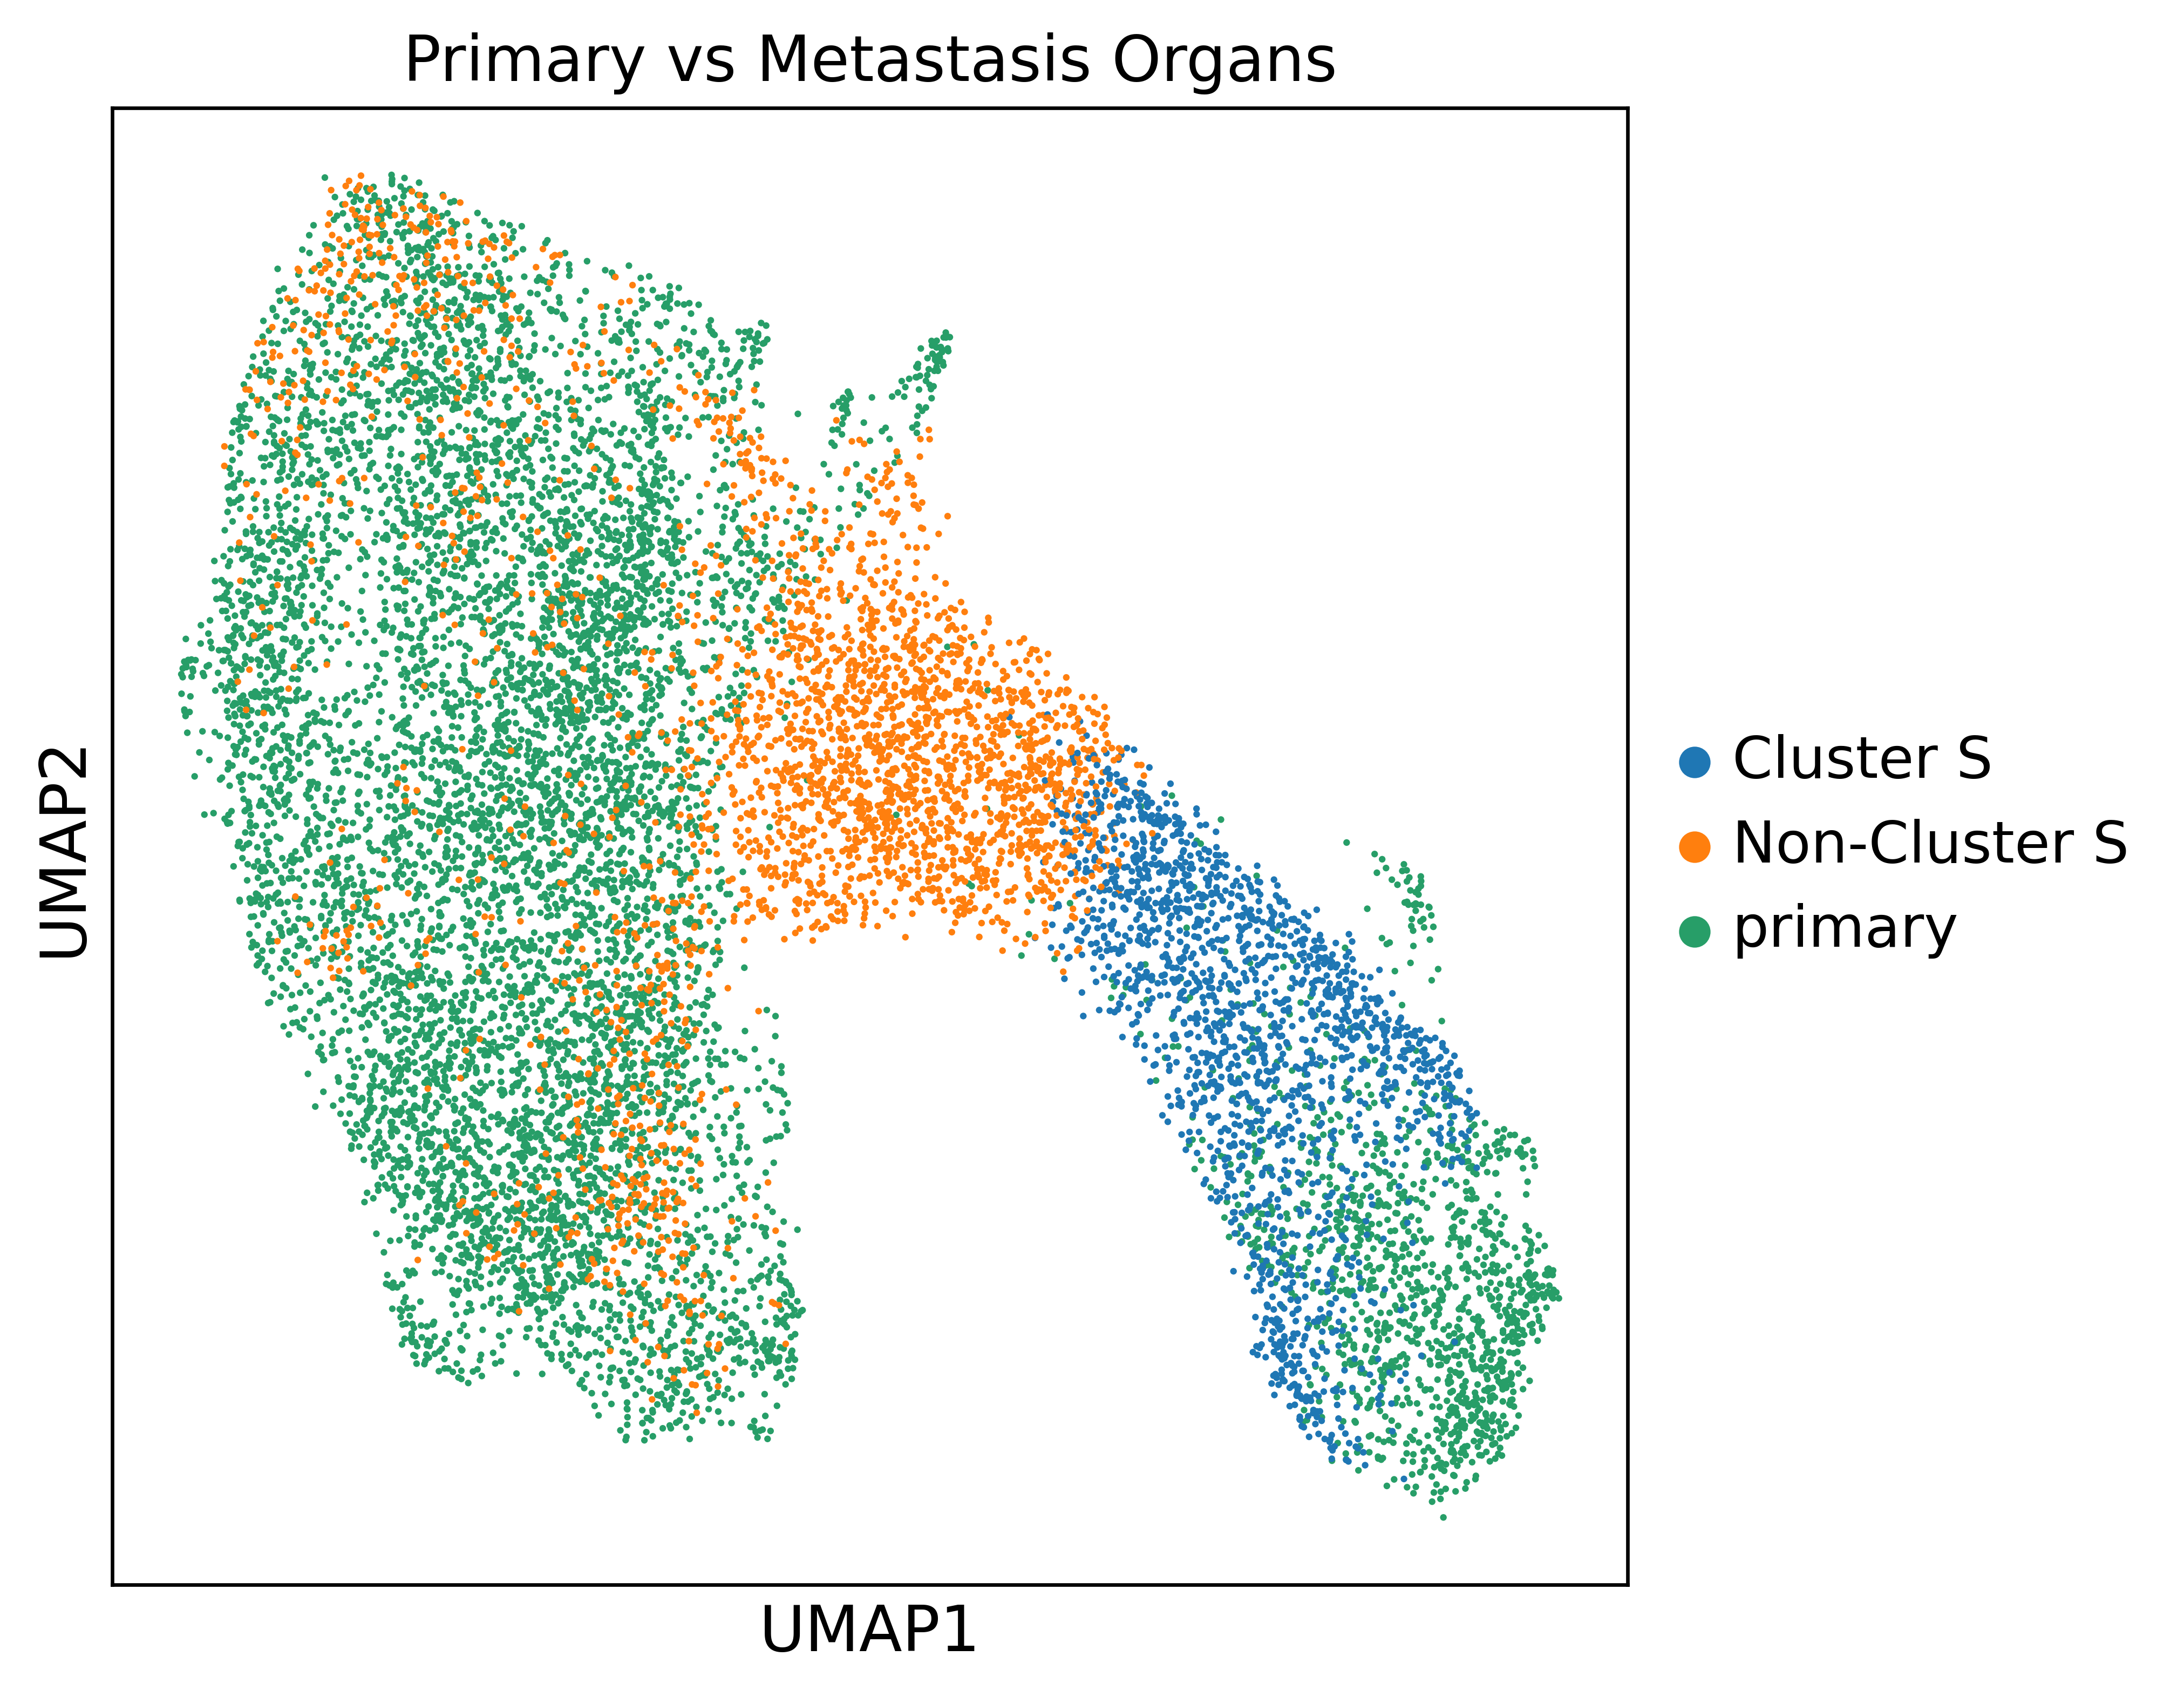

In [47]:
def plot_umap(
    adata: ad.AnnData,
    color: list[str] | str,
    title: str | None = None,
    save: str | None = None,
    show: bool = False,
    root_dir: Path | str | None = None,
) -> None:
    """
    Plot UMAP visualization.

    Args:
        adata: AnnData object to plot. Must have UMAP coordinates in adata.obsm["X_umap"].
        color: Column name(s) from adata.obs to color by. Can be a single string or list of strings.
            Each string should correspond to a column in adata.obs.
        title: Plot title. If None, scanpy will use default title.
        save: Filename to save plot. If None, plot is not saved. The filename should not include
            extension (scanpy will add appropriate extension based on format).
        show: Whether to display the plot interactively. If False, plot is only saved or not shown.
        root_dir: Directory to save plots. Only used if save is not None. If None and save is not None,
            uses scanpy's default figure directory.

    Returns:
        None. The plot is saved to file if save is specified, or displayed if show is True.

    Raises:
        KeyError: If color column(s) are not found in adata.obs
        ValueError: If UMAP coordinates are not found in adata.obsm["X_umap"]
    """
    if root_dir is not None:
        root_dir = Path(root_dir)
        root_dir.mkdir(parents=True, exist_ok=True)
        sc.settings.figdir = str(root_dir)

    adata_copy = adata.copy()
    # sc.pp.normalize_total(adata_copy)
    # sc.pp.log1p(adata_copy)
    sc.pp.pca(adata_copy)
    sc.pp.scale(adata_copy)
    sc.pp.neighbors(adata_copy)
    sc.tl.umap(adata_copy)

    sc.set_figure_params(
        dpi=300,
        figsize=(6, 6),
    )

    if save is not None:
        sc.pl.umap(adata_copy, color=color, title=title, save=save, show=show)
    else:
        sc.pl.umap(adata_copy, color=color, title=title, show=show)


# Plot and save combined UMAP

plot_umap(
    combined_adata,
    color=["dataset"],
    save=DOMAIN_UMAP,
    show=False,
    root_dir=output_dir,
    title="Primary vs Metastasis",
)
plot_umap(
    combined_adata,
    color=["organ"],
    save=ORGAN_UMAP,
    show=False,
    root_dir=output_dir,
    title="Organs",
)


# Plot and save combined UMAP with primary vs organs
def create_plot2_label(row):
    return "primary" if row["dataset"] == "primary" else row["organ"]


combined_adata.obs["plot2_label"] = combined_adata.obs.apply(create_plot2_label, axis=1)

plot_umap(
    combined_adata,
    color=["plot2_label"],
    title="Primary vs Metastasis Organs",
    save=PRIMARY_VS_ORGAN_UMAP,
    show=False,
    root_dir=output_dir,
)

plot_umap(
    combined_adata,
    color=["plot2_label"],
    title="Primary vs Metastasis Organs",
    show=False,
)

# Plot and save metastasis UMAP
if metastasis_adata is not None:
    plot_umap(
        metastasis_adata,
        color=["organ"],
        title="Metastasis Organs",
        save=METASTASIS_UMAP,
        show=False,
        root_dir=output_dir,
    )

# Plot and save primary UMAP
if primary_adata is not None:
    plot_umap(
        primary_adata,
        color=["organ"],
        title="Primary Organs",
        save=PRIMARY_UMAP,
        show=False,
        root_dir=output_dir,
    )